In [214]:
import json
import pandas as pd
import numpy as np
import jsonlines
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
%matplotlib inline
sns.set_style("whitegrid")

# import local modules
import getpbp
import getdata as gd
from BasketballCourt import get_layout

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',  None)
%load_ext autoreload
%autoreload 2
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix,accuracy_score,make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
import joblib

import statsmodels.api as sm
import scipy.stats as stats

import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'notebook'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Import data**

In [215]:
all_player_shots = pd.read_csv('../new_data/all_player_shots.csv')

In [216]:
all_player_shots.shape

(2983, 19)

In [217]:
all_player_shots.head()

,height,name,position,shotType,ACTIONTYPE,score_miss,eventType,HOMEDESCRIPTION,VISITORDESCRIPTION,gameClock,shotClock,period,x,y,closest_opponent_dist,game_id,HomeAway,opponent_importance,opponent_height
0,78.0,Draymond Green,F,3PT_SHOT,3PT,miss,SHOT,MISS Green 26' 3PT Jump Shot,NaN,379.60,1.3,1.0,29.58,-21.68,5.60,42100401,home,0.0486,80.0
1,78.0,Draymond Green,F,2PT_PAINT,2PT,miss,DRIBBLE SHOT,MISS Green 5' Running Layup,NaN,165.20,19.8,1.0,41.40,2.91,0.99,42100401,home,0.0429,76.0
2,78.0,Draymond Green,F,3PT_SHOT,3PT,miss,SHOT,MISS Green 3PT Jump Shot,NaN,85.20,7.9,1.0,41.75,22.46,14.50,42100401,home,0.0111,80.0
3,78.0,Draymond Green,F,2PT_PAINT,2PT,miss,SHOT,MISS Green 5' Cutting Layup Shot,Theis BLOCK (1 BLK),49.56,10.0,1.0,39.38,-0.85,2.16,42100401,home,0.0111,80.0
4,78.0,Draymond Green,F,2PT_PAINT,2PT,miss,SHOT,MISS Green 9' Floating Jump Shot,NaN,35.40,16.5,1.0,31.53,-3.74,5.74,42100401,home,0.0111,80.0


In [218]:
all_player_shots.columns

Index(['height', 'name', 'position', 'shotType', 'ACTIONTYPE', 'score_miss',
       'eventType', 'HOMEDESCRIPTION', 'VISITORDESCRIPTION', 'gameClock',
       'shotClock', 'period', 'x', 'y', 'closest_opponent_dist', 'game_id',
       'HomeAway', 'opponent_importance', 'opponent_height'],
      dtype='object')

**Feature Engineering**

In [219]:
model_df = all_player_shots[['shotType', 'shotClock', 'period', 'x', 'y',
       'closest_opponent_dist', 'height', 'position', 'HomeAway',
       'opponent_importance', 'score_miss', 'opponent_height']]

In [220]:
model_df['score_miss'] = model_df['score_miss'].replace({'score': 1, 'miss': 0}) 

In [221]:
model_df.dtypes

shotType                  object
shotClock                float64
period                   float64
x                        float64
y                        float64
closest_opponent_dist    float64
height                   float64
position                  object
HomeAway                  object
opponent_importance      float64
score_miss                 int64
opponent_height          float64
dtype: object

In [222]:
label_encoder = LabelEncoder()

In [223]:
object_cols = ['shotType', 'HomeAway', 'position']

In [224]:
# Label encode this for the feature importance process
for object_col in object_cols:
    model_df[object_col] = label_encoder.fit_transform(model_df[object_col])

In [225]:
def get_importance(df, target):
    '''
    Train a Random Forest Classifier on the given DataFrame `df` to predict the `target` column. 
    Show confusion matrix and plot feature importance     
    
    Args: df(dataframe): dataframe in format that fits Random Forest Classifier
          target(string): dependent variable
    '''
        
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=target), df[target], test_size=0.25, random_state=47)
    
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    feature_importances = rf_model.feature_importances_
    features = X_train.columns
    
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

    fig, ax = plt.subplots(figsize=(2, 2))  
    disp.plot(ax=ax,cmap=plt.cm.Blues, colorbar = False)  
    plt.grid(False)
    plt.show()  
    
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    sorted_feature_importance_df = sorted_feature_importance_df.reset_index(drop = True)
    print(sorted_feature_importance_df)

    plt.figure(figsize=(6, 4))
    plt.bar(sorted_feature_importance_df['Feature'], sorted_feature_importance_df['Importance'], color = 'lavender')
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importances in Random Forest (Best Model)')
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

           0       0.62      0.73      0.67       427
           1       0.53      0.41      0.46       319

    accuracy                           0.59       746
   macro avg       0.58      0.57      0.57       746
weighted avg       0.58      0.59      0.58       746



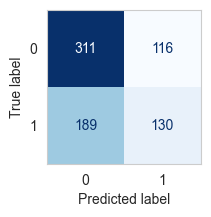

                  Feature  Importance
0                       x    0.172120
1                       y    0.160953
2   closest_opponent_dist    0.150184
3               shotClock    0.141825
4     opponent_importance    0.097970
5         opponent_height    0.066688
6                  height    0.066140
7                  period    0.048457
8                shotType    0.040740
9                position    0.033553
10               HomeAway    0.021370


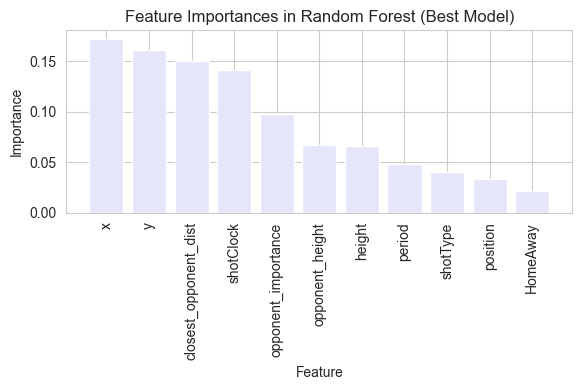

In [226]:
get_importance(model_df, 'score_miss')

<Axes: >

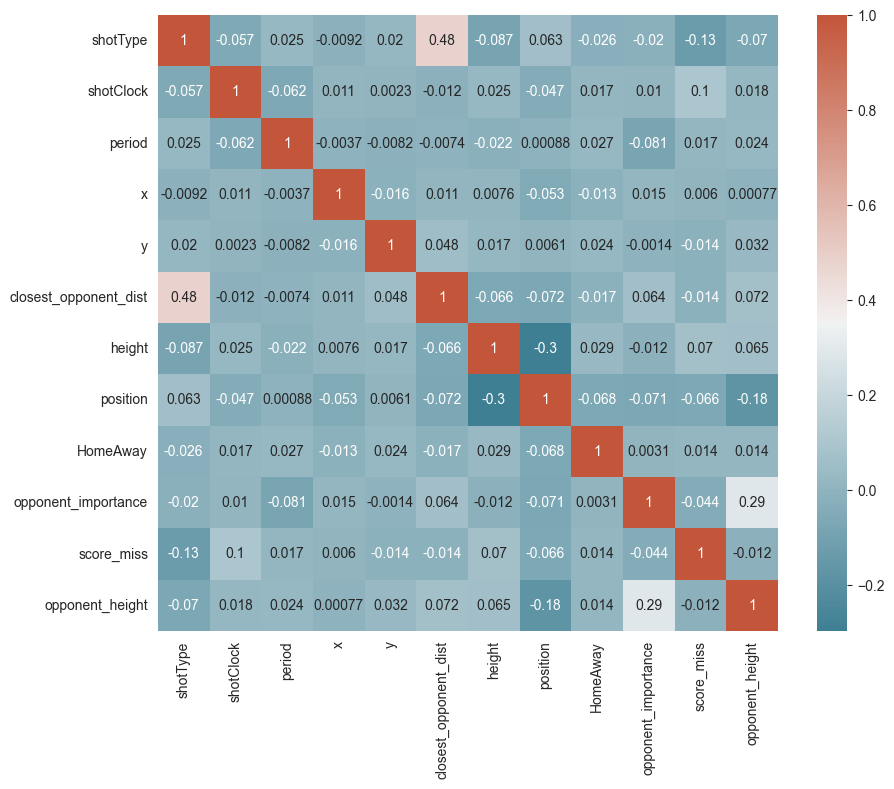

In [227]:
plt.subplots(figsize=(10,8))
sns.heatmap(model_df.corr(),annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [228]:
def stats_logi(df, target):
    '''
    Train a statsmodel logistic regression model on the given DataFrame `df` to predict the specified `target` column. 
    label scaled data with original column names and show model summry.   
    
    Args: df(dataframe): dataframe in format that fits statsmodel logistic regression model
          target(string): dependent variable    
    '''
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=target), df[target], test_size=0.25, random_state=47)
    for i in range(len(X_train.columns)):
        print('x'+str(i+1)+': '+X_train.columns[i])
        
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test= scaler.transform(X_test)    
    
    log_reg = sm.Logit(y_train,X_train).fit()
    print(log_reg.summary2())

In [229]:
stats_logi(model_df, 'score_miss')

x1: shotType
x2: shotClock
x3: period
x4: x
x5: y
x6: closest_opponent_dist
x7: height
x8: position
x9: HomeAway
x10: opponent_importance
x11: opponent_height
Optimization terminated successfully.
         Current function value: 0.672725
         Iterations 4
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: score_miss       Pseudo R-squared: 0.024     
Date:               2023-07-30 19:01 AIC:              3031.7695 
No. Observations:   2237             BIC:              3094.6113 
Df Model:           10               Log-Likelihood:   -1504.9   
Df Residuals:       2226             LL-Null:          -1541.5   
Converged:          1.0000           LLR p-value:      1.0245e-11
No. Iterations:     4.0000           Scale:            1.0000    
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-----------------------------------

- After reviewing all above, the decision is to drop HomeAway first, then check out position

**Compare model with and without 'position'**

In [230]:
model_df2 = all_player_shots[['shotType', 'shotClock', 'period', 'x', 'y',
       'closest_opponent_dist', 'height', 'position', 
       'opponent_importance', 'score_miss', 'opponent_height']]

In [231]:
model_df2['score_miss'] = model_df2['score_miss'].replace({'score': 1, 'miss': 0}) 

In [232]:
dummy_cols = ['shotType', 'period', 'position']

In [233]:
dummy_cols2 = ['shotType', 'period']

In [234]:
def get_dummy(df, dummy_cols):
    '''
    Conduct one-hot encoding on specified columns.
    Arg: df(dataframe): dataframe 
         dummy_cols(list): columns that need one-hot encoding
    return: transformed dataframe
    '''
    for col in dummy_cols:
        dummy = pd.get_dummies(df[col], prefix=col, drop_first=False, dtype=int)
        df = pd.concat([df, dummy], axis=1)
    df.drop(dummy_cols, axis = 1, inplace = True)
    return df

In [235]:
# Generate dataset with position column
model_df2_wp = get_dummy(model_df2, dummy_cols)

In [236]:
# Generate dataset without position column
model_df2_wop = get_dummy(model_df2, dummy_cols2)
model_df2_wop = model_df2_wop.drop(columns = 'position')

In [237]:
# Make pipeline for six classifiers
lr_pipeline = Pipeline([('lr', LogisticRegression())])
rf_pipeline = Pipeline([('rf', RandomForestClassifier())])
nb_pipeline = Pipeline([('nb', GaussianNB())])
xgb_pipeline = Pipeline([('xgb', XGBClassifier())])
svm_pipeline = Pipeline([('svm', SVC())])
dt_pipeline = Pipeline([('dt', DecisionTreeClassifier())])
pipelines = [lr_pipeline, rf_pipeline, nb_pipeline, xgb_pipeline, svm_pipeline, dt_pipeline]

In [238]:
def get_best_model(df, target, scale = True, oversampler = False):
    '''
    Train multiple classifier model on the given DataFrame `df` to predict the specified `target` column. 
    Print accuracy score of all models and print the confusion matrix of the one with highest score.   
    
    Args: df(dataframe): dataframe in format that fits models in pipelines
          target(string): dependent variable    
          scale(boolean): scaler or not
          oversampler(boolean): oversampler or not
    '''    
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), 
                                                    df[target], test_size=0.25, 
                                                    random_state=47)
    if scale == True:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test= scaler.transform(X_test)
    
    if oversampler == True:
        oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
    
    highest_accuracy = 0.0
    best_pipeline = None

    for pipeline in pipelines:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        model_name = pipeline.steps[-1][1].__class__.__name__
        print(f'{model_name} Accuracy: {accuracy:.2f}')

        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_pipeline = pipeline   
        else: pass
        
    print(' ')
    print('Best model: ' + best_pipeline.steps[-1][1].__class__.__name__)
    y_pred = best_pipeline.predict(X_test)
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=best_pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline.classes_)

    fig, ax = plt.subplots(figsize=(2, 2))  
    disp.plot(ax=ax,cmap=plt.cm.Blues, colorbar = False)  
    plt.grid(False)
    plt.show()     

LogisticRegression Accuracy: 0.64
RandomForestClassifier Accuracy: 0.60
GaussianNB Accuracy: 0.63
XGBClassifier Accuracy: 0.56
SVC Accuracy: 0.63
DecisionTreeClassifier Accuracy: 0.53
 
Best model: LogisticRegression
              precision    recall  f1-score   support

           0       0.66      0.77      0.71       427
           1       0.60      0.46      0.52       319

    accuracy                           0.64       746
   macro avg       0.63      0.62      0.62       746
weighted avg       0.63      0.64      0.63       746



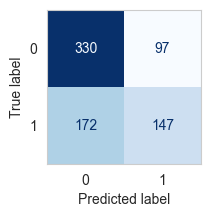

In [239]:
get_best_model(model_df2_wp, 'score_miss')

LogisticRegression Accuracy: 0.63
RandomForestClassifier Accuracy: 0.59
GaussianNB Accuracy: 0.62
XGBClassifier Accuracy: 0.57
SVC Accuracy: 0.62
DecisionTreeClassifier Accuracy: 0.52
 
Best model: LogisticRegression
              precision    recall  f1-score   support

           0       0.66      0.76      0.70       427
           1       0.59      0.47      0.52       319

    accuracy                           0.63       746
   macro avg       0.62      0.61      0.61       746
weighted avg       0.63      0.63      0.62       746



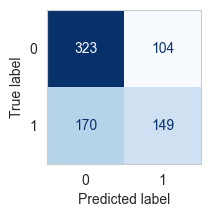

In [240]:
get_best_model(model_df2_wop, 'score_miss')

The results are very close. The data with position does slightly better with logistic regression

**Compare models binning or not binning cols with outliers ('closest_opponent_dist', 'opponent_importance', 'opponent_height')**

In [241]:
model_df3 = all_player_shots[['shotType', 'shotClock', 'period', 'x', 'y',
       'closest_opponent_dist', 'height', 'position', 
       'opponent_importance', 'score_miss', 'opponent_height']]

In [242]:
model_df3['score_miss'] = model_df3['score_miss'].replace({'score': 1, 'miss': 0}) 
model_df3 = get_dummy(model_df3, dummy_cols)

In [243]:
# Binning the features that potentially create noise
bin_edges_dict = {}
num_bins = 3
bin_cols = ['height', 'closest_opponent_dist', 'opponent_importance', 'opponent_height']
bin_labels = [0,1,2]
for bin_col in bin_cols:
    model_df3[bin_col], bin_edges = pd.qcut(model_df3[bin_col], labels = bin_labels, 
                                            q=num_bins, retbins=True)
    bin_edges_dict[bin_col] = bin_edges
    bin_edge_df = pd.DataFrame(zip(bin_edges, bin_labels), columns=['Threshold', 'Tier'])
    print(bin_edge_df)

   Threshold  Tier
0       72.0     0
1       77.0     1
2       79.0     2
   Threshold  Tier
0       0.83     0
1       3.26     1
2       5.02     2
   Threshold  Tier
0     0.0003     0
1     0.0238     1
2     0.0429     2
   Threshold  Tier
0       72.0     0
1       77.0     1
2       79.0     2


In [244]:
bin_edges_dict

{'height': array([72., 77., 79., 86.]),
 'closest_opponent_dist': array([ 0.83,  3.26,  5.02, 38.67]),
 'opponent_importance': array([0.0003, 0.0238, 0.0429, 0.0664]),
 'opponent_height': array([72., 77., 79., 86.])}

LogisticRegression Accuracy: 0.65
RandomForestClassifier Accuracy: 0.56
GaussianNB Accuracy: 0.64
XGBClassifier Accuracy: 0.57
SVC Accuracy: 0.63
DecisionTreeClassifier Accuracy: 0.54
 
Best model: LogisticRegression
              precision    recall  f1-score   support

           0       0.66      0.80      0.73       427
           1       0.63      0.46      0.53       319

    accuracy                           0.65       746
   macro avg       0.65      0.63      0.63       746
weighted avg       0.65      0.65      0.64       746



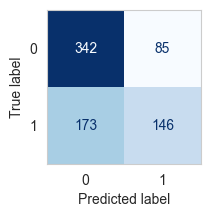

In [245]:
get_best_model(model_df3, 'score_miss')

The model after binning performs better 

**Bring in GridSearch**

In [246]:
def logistic_Grid_CV(df, target, scale = True, oversampler = False):
    '''
    Train logistic regression model and execute GridSearch on the given DataFrame `df` to predict the specified `target` column. 
    Print the confusion matrix.   
    
    Args: df(dataframe): dataframe in format that fits logistic regression model.
          target(string): dependent variable    
          scale(boolean): scaler or not
          oversampler(boolean): oversampler or not
    '''   
    
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=target), df[target], test_size=0.25, random_state=47)

    if scale == True:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test= scaler.transform(X_test)
    
    if oversampler == True:
        oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
        
    param_grid = {
        'C': [0.01, 0.1, 0.5, 1.0, 10.0, 50.0],  
        'penalty': ['l1', 'l2'],           
        'solver': ['lbfgs', 'liblinear', 'saga', 'newton-cholesky'],   
        'max_iter': [100, 500, 1000]       
    }
    
    logistic_model = LogisticRegression() 
    grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring=make_scorer(accuracy_score))
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    print("Best hyperparameters:", best_params)
    best_logistic_model = grid_search.best_estimator_

    y_pred = best_logistic_model.predict(X_test)
    
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=best_logistic_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_logistic_model.classes_)

    fig, ax = plt.subplots(figsize=(2, 2))  
    disp.plot(ax=ax,cmap=plt.cm.Blues, colorbar = False)  
    plt.grid(False)
    plt.show() 

Best hyperparameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.64      0.81      0.72       427
           1       0.60      0.38      0.47       319

    accuracy                           0.63       746
   macro avg       0.62      0.60      0.59       746
weighted avg       0.62      0.63      0.61       746



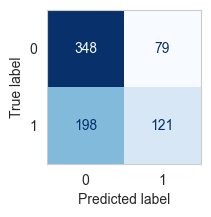

In [247]:
logistic_Grid_CV(model_df3, 'score_miss')

Somehow it performs worse than before.

- Check the hyperparameters of previous model

Default hyperparameters for Logistic Regression:
C: 1.0
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: None
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False
              precision    recall  f1-score   support

           0       0.66      0.80      0.73       427
           1       0.63      0.46      0.53       319

    accuracy                           0.65       746
   macro avg       0.65      0.63      0.63       746
weighted avg       0.65      0.65      0.64       746



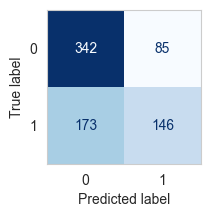

In [248]:
X_train, X_test, y_train, y_test = train_test_split(
    model_df3.drop(columns='score_miss'), model_df3['score_miss'], test_size=0.25, random_state=47)

logistic_model = LogisticRegression()

logistic_model.fit(X_train, y_train)

# Access the hyperparameters from the fitted model
hyperparameters = logistic_model.get_params()

print("Default hyperparameters for Logistic Regression:")
for param, value in hyperparameters.items():
    print(f"{param}: {value}")

y_pred = logistic_model.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=logistic_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_model.classes_)

fig, ax = plt.subplots(figsize=(2, 2))  
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)  
plt.grid(False)
plt.show()

**Decision:** 
- The best model is LogisticRegression with binned columns and default hyperparameters 
- The final features are ['shotType', 'shotClock', 'period', 'x', 'y', 'closest_opponent_dist', 'height', 'position', 'opponent_importance', 'opponent_height']

**Use the best model to predict shot result of each player**

Here I created an indicator ‘bX’, short for ‘beyond expectation’. As the shot success prediction model was built upon shot information of all shots made by all players, it reflects an overall shooting ability. Therefore, I use the model to predict each player’s previous shots. If a player scores while the model predicts ‘miss’ based on the scenario, the player performances beyond expectation and receives positive bX points, and vice versa.

In [249]:
bin_edges_dict

{'height': array([72., 77., 79., 86.]),
 'closest_opponent_dist': array([ 0.83,  3.26,  5.02, 38.67]),
 'opponent_importance': array([0.0003, 0.0238, 0.0429, 0.0664]),
 'opponent_height': array([72., 77., 79., 86.])}

In [250]:
def transform_df(df):
    '''
    Transform a dataframe to match the columns of previously modeled dataset.
    Arg: df(dataframe)
    Return: transformed dataframe
    '''
    
    df = df[['shotType', 'shotClock', 'period', 'x', 'y',
       'closest_opponent_dist', 'height', 'position', 
       'opponent_importance', 'score_miss', 'opponent_height']]
    df['score_miss'] = df['score_miss'].replace({'score': 1, 'miss': 0}) 
    df = get_dummy(df, dummy_cols)
    
    # Use previous save the bin_edges so it's cut the same way
    for bin_col in bin_cols:
        df[bin_col]= pd.cut(df[bin_col], bins = bin_edges_dict[bin_col], labels=bin_labels, include_lowest = True)
      
    return df

In [251]:
player_counts = all_player_shots['name'].value_counts()
player_list = player_counts[player_counts > 10].index.tolist()
len(player_list)

40

In [252]:
bX_dict = {}

In [253]:
for player in player_list:
    # Get all shots for specified player
    df_t = all_player_shots[all_player_shots['name'] == player]
    # Transform df to match model
    df_t = transform_df(df_t)
    df_X = df_t.drop(columns = 'score_miss')
    
    # Add missing cols caused by one-hot encoding
    for col in X_train.columns:
        if col not in df_X.columns:
            df_X[col] = 0
    
    #Ensure the df structure exactly matches training data
    assert set(df_X.columns) == set(X_train.columns)
    df_X = df_X[X_train.columns]
    
    # Predict shot result using previous model
    df_t['predict'] = logistic_model.predict(df_X)
    
    # Generate bX Score 
    df_t['compare'] = df_t['score_miss'] - df_t['predict']
    bX_dict[player] = df_t['compare'].mean().round(3)

Text(0.5, 1.0, 'Player bX')

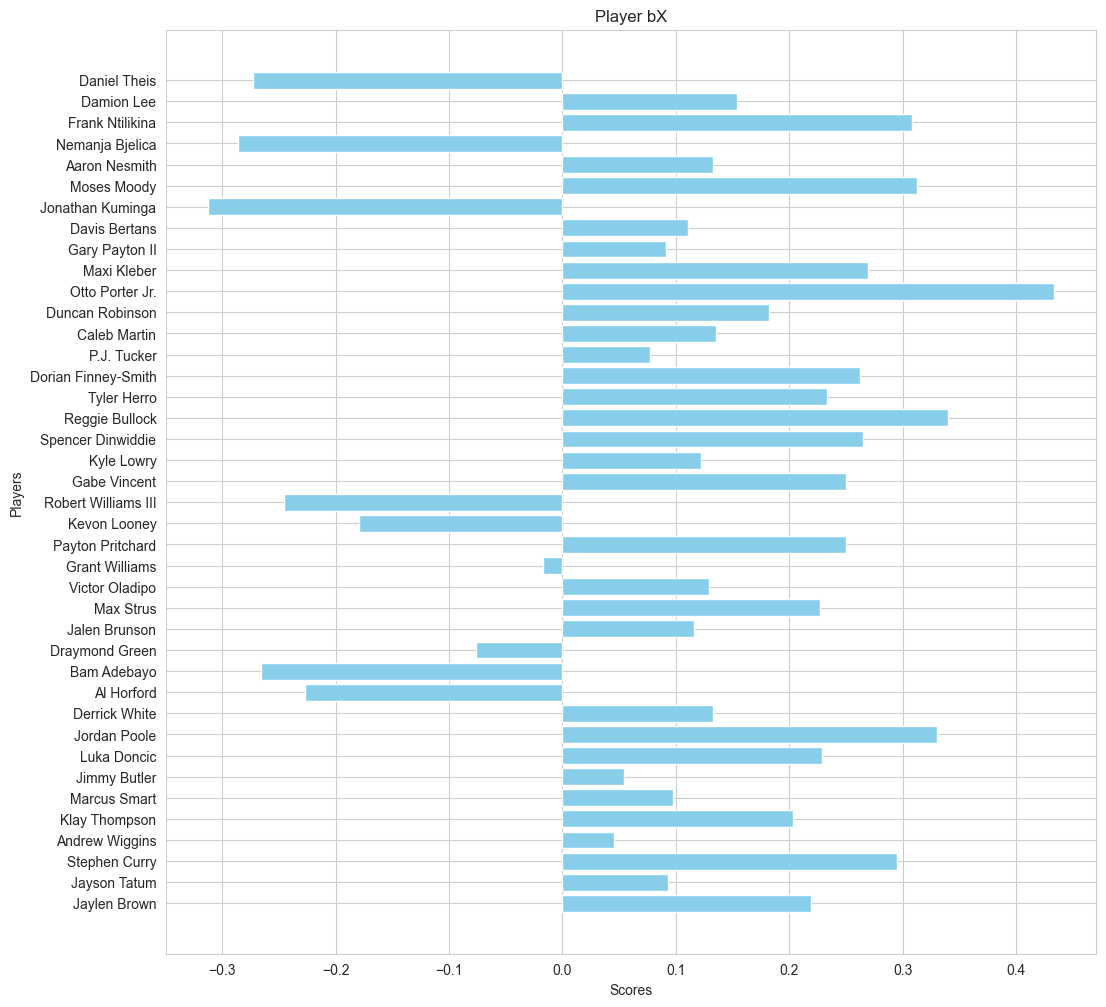

In [254]:
players = list(bX_dict.keys())
scores = list(bX_dict.values())
plt.figure(figsize=(12, 12))
plt.barh(players, scores, color='skyblue')
plt.xlabel('Scores')
plt.ylabel('Players')
plt.title('Player bX')

In [255]:
# Save dictionary for application
with open('../new_data/bX_dict.json', "w") as json_file:
    json.dump(bX_dict, json_file)

In [256]:
shotTypes = all_player_shots['shotType'].unique()

In [257]:
bX_shotType_dict = {}

In [258]:
for player in player_list:
    
    bX_shotType_dict[player] = {}
    df_t0 = all_player_shots[all_player_shots['name'] == player]
    
    for shotType in shotTypes:
        df_t = df_t0[df_t0['shotType'] == shotType]
        if df_t.empty:
            continue
        
        df_t = transform_df(df_t)
        
        df_X = df_t.drop(columns = 'score_miss')

        for col in X_train.columns:
            if col not in df_X.columns:
                df_X[col] = 0

        assert set(df_X.columns) == set(X_train.columns)
        df_X = df_X[X_train.columns]

        df_t['predict'] = logistic_model.predict(df_X)

        df_t['true'] = df_t['score_miss'].replace({'score': 1, 'miss': 0})
        df_t['compare'] = df_t['true'] - df_t['predict']
        bX_shotType_dict[player][shotType] = df_t['compare'].mean().round(3)

In [259]:
# Save dictionary for application
with open('../new_data/bX_shotType_dict.json', "w") as json_file:
    json.dump(bX_shotType_dict, json_file)